# <div style="text-align: center">Random Forests - Hohenberg-Kohn Mapping</div> 
 
## <div style="text-align: center">Jon Vandermause, Steven Torrisi, Simon Batzner</div> 

## <div style="text-align: center">Gaussian Potential-to-Density </div> 

In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from KRR_reproduce import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
SIM_NO = 150
seed = 42

# setup
ev2kcal = 1/0.043     # conversion factor
SIM_NO = 150          # total number of data points
SEED = 42
M = 140               # number of training points
GRID_SPACE = 0.8      # grid spacing for gaussian potential (see [1])

# random forest
N_ESTIMATORS = 1000    # number of treest
MAX_DEPTH = 50        # maximum depth of the tree

# # alternate params
# N_ESTIMATORS = 100    # number of treest
# MAX_DEPTH = 20      # maximum depth of the tree


# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR'] + '/data/H2_DFT/temp_data/store/'

## Load data

In [16]:
ens = []
seps = []
fours = []

for n in range(SIM_NO):
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')
    four = np.load(STR_PREF + 'four_store/four' + str(n) + '.npy')

    # put results in a nicer format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']
    four = np.real(four)

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

## Create gaussian potentials

In [17]:
pots = []
grid_len = 5.29177 * 2
fours_flattened = []

for n in range(SIM_NO):
    dist = seps[n]
    pot = pot_rep(dist, grid_len, grid_space=GRID_SPACE)
    pot = pot.flatten()
    pots.append(pot)
    four = fours[n]
    four = four.flatten()
    fours_flattened.append(four)

In [18]:
data = pots
labels = fours_flattened

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,149,M))]
test_indices = [n for n in range(150) if n not in train_indices]

if len(train_indices) != M: 
    print("Size of training set doesn't match the M specified")
    
x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test =np.array([labels[n] for n in test_indices])
x_seps_test = np.array([seps[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_test.shape)
print(x_seps_test.shape)

(10, 2744)
(140, 15625)
(140,)


In [19]:
# train random forest
MAX_FEATURES = x_train.shape[1] // 3
estimator = RandomForestRegressor(random_state=0, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, max_features = MAX_FEATURES)
print("Training...\n")
estimator.fit(x_train, y_train)

Training...



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=914, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
# eval on training data
y_true_train, y_pred_train = y_train, estimator.predict(x_train)

# eval on test data
y_true, y_pred = y_test, estimator.predict(x_test)

print("Number of estimators: {}".format(N_ESTIMATORS))
print("Maximum depth: {}".format(MAX_DEPTH))
print("\nMAE on training data in [kcal/mol]:\t{}".format(mean_absolute_error(y_true_train, y_pred_train)*ev2kcal))
print("MAE on test data in [kcal/mol]:\t\t{}".format(mean_absolute_error(y_true, y_pred)*ev2kcal))

print("\nPredicted Fourier components:\n")
print(y_pred)

y_pot2four_pred = y_pred

Number of estimators: 1000
Maximum depth: 50

MAE on training data in [kcal/mol]:	14.398950792380392
MAE on test data in [kcal/mol]:		12.472724334847085

Predicted Fourier components:

[[  4.88281714e+02  -4.72044646e+02   4.28274843e+02 ...,  -6.02663355e-02
    4.85761922e-02  -3.81800279e-02]
 [  4.88281714e+02  -4.72044646e+02   4.28274843e+02 ...,  -6.02663355e-02
    4.85761922e-02  -3.81800279e-02]
 [  4.88281714e+02  -4.72044646e+02   4.28274843e+02 ...,  -6.02663355e-02
    4.85761922e-02  -3.81800279e-02]
 ..., 
 [  4.88281794e+02  -4.63316715e+02   3.99283418e+02 ...,  -2.23036611e-02
    1.80175409e-02  -1.42067041e-02]
 [  4.88281794e+02  -4.63298371e+02   3.99223828e+02 ...,  -2.23320323e-02
    1.80404492e-02  -1.42247446e-02]
 [  4.88281794e+02  -4.63298371e+02   3.99223828e+02 ...,  -2.23320323e-02
    1.80404492e-02  -1.42247446e-02]]


## <div style="text-align: center">Density-to-Energy </div> 

In [21]:
# setup
SIM_NO = 150
SEED = 42
M = 10               # number of training points

# random forest params (found from hyperparameter optimization)  
# N_ESTIMATORS = 50
# MAX_DEPTH = 10

N_ESTIMATORS = 1000
MAX_DEPTH = 50



print("Number of estimators: {}".format(N_ESTIMATORS))
print("Maximum depth: {}".format(MAX_DEPTH))

Number of estimators: 1000
Maximum depth: 50


In [22]:
data = fours_flattened
labels = ens

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,149,M))]
test_indices = [n for n in range(150) if n not in train_indices]

if len(train_indices) != M: 
    print("Size of training set doesn't match the M specified")
    
x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test =np.array([labels[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_test.shape)

(10, 15625)
(140,)


## Set up training and test data

In [23]:
# train random forest
MAX_FEATURES = x_train.shape[1] // 3
estimator = RandomForestRegressor(random_state=0, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, max_features = MAX_FEATURES)
print("Training...\n")
estimator.fit(x_train, y_train)

Training...



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=5208, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
# eval on training data
y_true_train, y_pred_train = y_train, estimator.predict(x_train)

# eval on test data
y_true, y_pred = y_test, estimator.predict(x_test)

print("Number of estimators: {}".format(N_ESTIMATORS))
print("Maximum depth: {}".format(MAX_DEPTH))
print("\nMAE on training data in [kcal/mol]:\t{}".format(mean_absolute_error(y_true_train, y_pred_train)*ev2kcal))
print("MAE on test data in [kcal/mol]:\t{}".format(mean_absolute_error(y_true, y_pred)*ev2kcal))

print("\nPredicted Energy:\n")
y_pred[0]

Number of estimators: 1000
Maximum depth: 50

MAE on training data in [kcal/mol]:	3.377323477344585
MAE on test data in [kcal/mol]:	2.8332983759046173

Predicted Energy:



-30.20872474666287

## Now let's compare to generated data from the first mapping

In [25]:
# eval on generated data from first mapping
y_true, y_pred = y_test, estimator.predict(y_pot2four_pred)
print("\nMAE on generated data in [kcal/mol]:\t{}".format(mean_absolute_error(y_true, y_pred)*ev2kcal))

print("\n    Pred \t|   True\n")
print(np.c_[y_pred, y_true])


MAE on generated data in [kcal/mol]:	5.149199774639875

    Pred 	|   True

[[-30.42608277 -29.86480944]
 [-30.42608277 -30.00126384]
 [-30.42608277 -30.13048409]
 [-30.40772335 -30.25205876]
 [-30.49653134 -30.36705412]
 [-30.49653134 -30.47510758]
 [-30.51906203 -30.57717032]
 [-30.51906203 -30.67320233]
 [-30.71260002 -30.7632198 ]
 [-30.71260002 -30.84802303]
 [-30.84743473 -30.92735568]
 [-30.86620394 -31.00192919]
 [-30.86620394 -31.07152411]
 [-30.8693781  -31.13677132]
 [-30.87246905 -31.19766036]
 [-30.87246905 -31.25422224]
 [-30.9477312  -31.35579816]
 [-30.9477312  -31.40113248]
 [-30.9477312  -31.44287327]
 [-30.9477312  -31.48142229]
 [-30.9477312  -31.51679575]
 [-30.96691676 -31.54904043]
 [-31.04130015 -31.57847976]
 [-31.05556451 -31.60506448]
 [-31.06009509 -31.62907309]
 [-31.05586469 -31.65047649]
 [-31.12204955 -31.66951141]
 [-31.12378211 -31.68621403]
 [-31.1270674  -31.70064478]
 [-31.12822985 -31.71298488]
 [-31.21025415 -31.72325065]
 [-31.21025415 -31.73803

Text(0.5,0,'Distance [Angstrom]')

Text(0,0.5,'Energy [eV]')

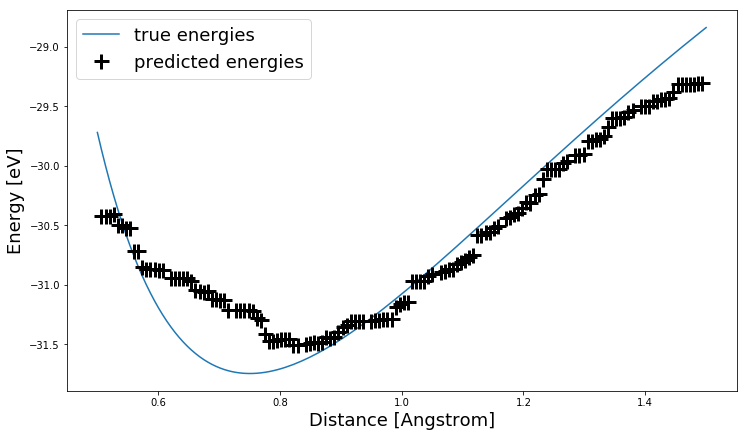

In [26]:
fig = plt.figure(figsize=(12, 7));
plt.plot(seps, ens, label='true energies'); 
plt.plot(x_seps_test, y_pred, 'k+', MarkerSize = 15, mew = 3, label = 'predicted energies'); 
plt.legend(fontsize = 18);
plt.xlabel('Distance [Angstrom]', fontsize = 18);
plt.ylabel('Energy [eV]', fontsize = 18);
plt.show()

For comparison, from [1]: "The MAE that is introduced by the PBE approximation on the H2 data set is 2.3 kcal/mol (compared to exact CI calculations)"" 

[1] Brockherde et al. Bypassing the Kohn-Sham equations with machine learning. Nature Communications 8, 872 (2017)